In [126]:
import numpy as np
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm #progress bar library -- not necessary, but helpful since some of this is slower

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
%matplotlib inline
sns.set()

In [3]:
df = pd.read_pickle('raw_data.pkl')

In [4]:
df = df[df.season == '2020-21']

In [5]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21
66818,Aaron Cresswell,2.0,West Ham,0,0,11,0,11.2,435,6,2,0,2.2,10.4,2020-09-12T19:00:00Z,90,14,1,2.0,0.0,1,50,True,1,2020-21
66819,Aaron Mooy,3.0,Brighton,0,0,0,0,0.0,60,7,0,0,0.0,0.0,2020-09-14T19:15:00Z,0,5,1,3.0,1.0,0,50,True,1,2020-21
66820,Aaron Ramsdale,1.0,Sheffield Utd,0,0,12,0,0.0,483,8,2,0,1.8,18.2,2020-09-14T17:00:00Z,90,20,1,2.0,0.0,1,50,True,1,2020-21
66821,Abdoulaye DoucourÃ©,3.0,Everton,0,0,20,1,44.6,512,4,0,0,6.9,20.4,2020-09-13T15:30:00Z,90,17,1,1.0,0.0,3,55,False,1,2020-21


In [6]:
# df = df[df.position > 1] #going to focus on analysis of field players, don't want correlations of goalkeepers to throw off findings

In [7]:
df.groupby('name').mean().corr()['total_points'].sort_values(ascending=False)

total_points      1.000000
influence         0.953649
bps               0.952645
ict_index         0.923237
minutes           0.919305
clean_sheets      0.903762
bonus             0.871294
goals_conceded    0.811336
creativity        0.737320
assists           0.714016
goals_scored      0.701606
value             0.600603
position          0.087334
team_a_score      0.059693
was_home          0.003517
team_h_score      0.003085
opponent_team     0.002566
element          -0.232106
fixture          -0.272767
round            -0.275324
gw               -0.275324
Name: total_points, dtype: float64

In [8]:
df['pp90'] = (df['total_points']/df['minutes']) * 90

In [9]:
df = df[df['minutes'] > 0]
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000
66818,Aaron Cresswell,2.0,West Ham,0,0,11,0,11.2,435,6,2,0,2.2,10.4,2020-09-12T19:00:00Z,90,14,1,2.0,0.0,1,50,True,1,2020-21,1.000000
66820,Aaron Ramsdale,1.0,Sheffield Utd,0,0,12,0,0.0,483,8,2,0,1.8,18.2,2020-09-14T17:00:00Z,90,20,1,2.0,0.0,1,50,True,1,2020-21,1.000000
66821,Abdoulaye DoucourÃ©,3.0,Everton,0,0,20,1,44.6,512,4,0,0,6.9,20.4,2020-09-13T15:30:00Z,90,17,1,1.0,0.0,3,55,False,1,2020-21,3.000000
66822,Aboubakar Kamara,3.0,Fulham,0,0,-2,0,1.8,190,2,3,0,0.2,0.0,2020-09-12T11:30:00Z,62,1,1,3.0,0.0,2,50,True,1,2020-21,2.903226


In [10]:
prev_5_pp90 = []
prev_5_std = []
prev_5_max = []
prev_5_ict = []
prev_5_assists = []
prev_5_bps = []
fwd_4_pp90 = []

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)

df = df.sort_values(['name', 'kickoff_time'])

for player in df.name.unique():
    prev_5_pp90.extend(df[df['name'] == player].rolling(5)['pp90'].mean())
    prev_5_std.extend(df[df['name'] == player].rolling(5)['pp90'].std())
    prev_5_max.extend(df[df['name'] == player].rolling(5)['pp90'].max())
    prev_5_ict.extend(df[df['name'] == player].rolling(5)['ict_index'].mean())
    prev_5_assists.extend(df[df['name'] == player].rolling(5)['assists'].mean())
    prev_5_bps.extend(df[df['name'] == player].rolling(5)['bps'].mean())
    fwd_4_pp90.extend(df[df['name'] == player].rolling(window=indexer)['pp90'].mean())

df['prev_5_pp90'] = prev_5_pp90
df['prev_5_std'] = prev_5_std
df['prev_5_max'] = prev_5_max
df['prev_5_ict'] = prev_5_ict
df['prev_5_assists'] = prev_5_assists
df['prev_5_bps'] = prev_5_bps
df['fwd_4_pp90'] = fwd_4_pp90

In [11]:
prev_3_pp90 = []
prev_3_std = []
prev_3_max = []
prev_3_ict = []
prev_3_assists = []
prev_3_bps = []
fwd_4_pp90 = []

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)

df = df.sort_values(['name', 'kickoff_time'])

for player in df.name.unique():
    prev_3_pp90.extend(df[df['name'] == player].rolling(3)['pp90'].mean())
    prev_3_std.extend(df[df['name'] == player].rolling(3)['pp90'].std())
    prev_3_max.extend(df[df['name'] == player].rolling(3)['pp90'].max())
    prev_3_ict.extend(df[df['name'] == player].rolling(3)['ict_index'].mean())
    prev_3_assists.extend(df[df['name'] == player].rolling(3)['assists'].mean())
    prev_3_bps.extend(df[df['name'] == player].rolling(3)['bps'].mean())
    fwd_4_pp90.extend(df[df['name'] == player].rolling(window=indexer)['pp90'].mean())

df['prev_3_pp90'] = prev_3_pp90
df['prev_3_std'] = prev_3_std
df['prev_3_max'] = prev_3_max
df['prev_3_ict'] = prev_3_ict
df['prev_3_assists'] = prev_3_assists
df['prev_3_bps'] = prev_3_bps
df['fwd_4_pp90'] = fwd_4_pp90

In [12]:
prev_7_pp90 = []
prev_7_std = []
prev_7_max = []
prev_7_ict = []
prev_7_assists = []
prev_7_bps = []
fwd_4_pp90 = []

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)

df = df.sort_values(['name', 'kickoff_time'])

for player in df.name.unique():
    prev_7_pp90.extend(df[df['name'] == player].rolling(7)['pp90'].mean())
    prev_7_std.extend(df[df['name'] == player].rolling(7)['pp90'].std())
    prev_7_max.extend(df[df['name'] == player].rolling(7)['pp90'].max())
    prev_7_ict.extend(df[df['name'] == player].rolling(7)['ict_index'].mean())
    prev_7_assists.extend(df[df['name'] == player].rolling(7)['assists'].mean())
    prev_7_bps.extend(df[df['name'] == player].rolling(7)['bps'].mean())
    fwd_4_pp90.extend(df[df['name'] == player].rolling(window=indexer)['pp90'].mean())

df['prev_7_pp90'] = prev_7_pp90
df['prev_7_std'] = prev_7_std
df['prev_7_max'] = prev_7_max
df['prev_7_ict'] = prev_7_ict
df['prev_7_assists'] = prev_7_assists
df['prev_7_bps'] = prev_7_bps
df['fwd_4_pp90'] = fwd_4_pp90

In [13]:
df.corr()['fwd_4_pp90'].sort_values(ascending=False)

fwd_4_pp90        1.000000
pp90              0.563389
prev_3_pp90       0.445066
prev_3_max        0.434810
prev_3_std        0.424579
prev_5_pp90       0.408333
prev_5_max        0.405994
prev_5_std        0.403845
prev_7_pp90       0.385509
prev_7_max        0.378984
prev_7_std        0.377955
position          0.153730
goals_scored      0.065894
assists           0.033743
value             0.032328
bonus             0.025539
prev_3_assists    0.022731
prev_5_assists    0.021712
prev_7_assists    0.020172
element           0.018690
team_h_score      0.018656
total_points      0.009536
opponent_team     0.002559
team_a_score     -0.002486
was_home         -0.002957
prev_7_ict       -0.022553
prev_5_ict       -0.030050
fixture          -0.030444
gw               -0.032868
round            -0.032868
prev_3_ict       -0.044408
creativity       -0.044456
ict_index        -0.045207
clean_sheets     -0.053534
influence        -0.076275
bps              -0.079015
prev_3_bps       -0.139490
p

In [20]:
df['prev_pp90_index'] = ((df['prev_3_pp90'] * 50) + (df['prev_5_pp90'] * 30) + (df['prev_7_pp90'] * 20)) / 100
#simple, gut-driven hueristic does slightly better than just picking the previous 3 points per 90

In [21]:
df.corr()['fwd_4_pp90'].sort_values(ascending=False)

fwd_4_pp90         1.000000
pp90               0.563389
prev_3_pp90        0.445066
prev_pp90_index    0.442772
prev_3_max         0.434810
prev_3_std         0.424579
prev_5_pp90        0.408333
prev_5_max         0.405994
prev_5_std         0.403845
prev_7_pp90        0.385509
prev_7_max         0.378984
prev_7_std         0.377955
position           0.153730
goals_scored       0.065894
assists            0.033743
value              0.032328
bonus              0.025539
prev_3_assists     0.022731
prev_5_assists     0.021712
prev_7_assists     0.020172
element            0.018690
team_h_score       0.018656
total_points       0.009536
opponent_team      0.002559
team_a_score      -0.002486
was_home          -0.002957
prev_7_ict        -0.022553
prev_5_ict        -0.030050
fixture           -0.030444
round             -0.032868
gw                -0.032868
prev_3_ict        -0.044408
creativity        -0.044456
ict_index         -0.045207
clean_sheets      -0.053534
influence         -0

In [22]:
#simple, gut-driven hueristic does slightly better than just picking the previous 3 points per 90

In [23]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,prev_5_assists,prev_5_bps,fwd_4_pp90,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_pp90_index
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67242,Aaron Connolly,4.0,Brighton,0,2,27,1,11.3,78,16,0,1,6.9,34.8,2020-09-20T13:00:00Z,89,14,2,3.0,0.0,8,55,False,2,2020-21,8.089888,NaN,NaN,NaN,NaN,NaN,NaN,10.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67781,Aaron Connolly,4.0,Brighton,0,0,2,0,12.1,78,19,2,0,1.9,0.0,2020-09-26T11:30:00Z,73,13,3,3.0,2.0,2,55,True,3,2020-21,2.465753,NaN,NaN,NaN,NaN,NaN,NaN,14.433746,4.185214,3.389556,8.089888,4.066667,0.000000,8.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68335,Aaron Connolly,4.0,Brighton,0,0,7,0,0.3,78,32,3,0,0.7,3.0,2020-10-03T14:00:00Z,65,7,4,2.0,4.0,2,55,False,4,2020-21,2.769231,NaN,NaN,NaN,NaN,NaN,NaN,14.543114,4.441624,3.163131,8.089888,3.166667,0.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68897,Aaron Connolly,4.0,Brighton,1,0,13,0,10.3,78,40,0,0,3.0,17.2,2020-10-18T13:00:00Z,12,6,5,1.0,1.0,4,55,False,5,2020-21,30.000000,9.064974,11.961669,30.0,3.18,0.2,9.2,14.565092,11.744995,15.810026,30.000000,1.866667,0.333333,7.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#pts per 90 does some weird things for players who played small number of minutes
df = df[df.minutes > 30]

In [25]:
#dataframe that select the top 30 performers for each gameweek, by pp90
top_30_gw = df.sort_values('pp90', ascending=False).groupby('gw').head(30).sort_values('gw')

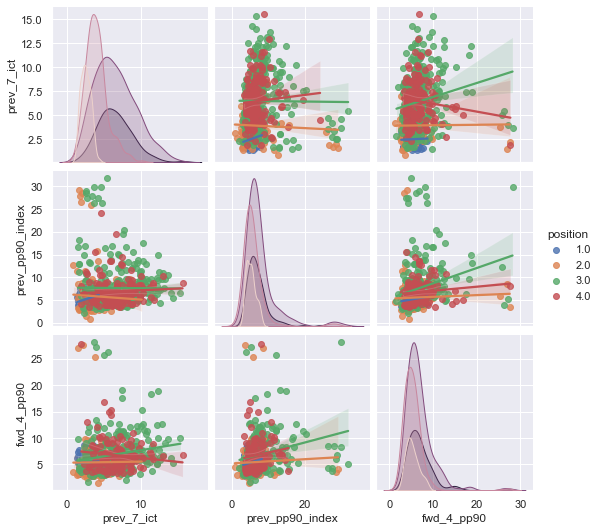

In [26]:
sns.pairplot(top_30_gw.loc[:, ['position',  'prev_7_ict', 'prev_pp90_index', 'fwd_4_pp90']], kind='reg', hue='position')

In [27]:
#recent history of midfielders is more reliable than recent history of forwards using the points per 90 index
#prev_7_ict looks like a fairly affective indicator for forwards

In [28]:
#ict is not a predictor of future performance

In [29]:
team_df = df.loc[:, ['team', 'was_home', 'team_a_score', 'team_h_score', 'gw']]

In [30]:
team_df['g'] = team_df.loc[team_df['was_home'] == True, 'team_h_score']
team_df['g_away'] = team_df.loc[team_df['was_home'] == False, 'team_a_score']
team_df['ga'] = team_df.loc[team_df['was_home'] == True, 'team_a_score']
team_df['ga_away'] = team_df.loc[team_df['was_home'] == False, 'team_h_score']

In [31]:
team_df = team_df.fillna(value=0)
team_df['g'] = team_df['g'] + team_df['g_away']
team_df['ga'] = team_df['ga'] + team_df['ga_away']
team_df = team_df.drop(columns=['g_away', 'ga_away'])

In [32]:
team_df = team_df.sort_values(['team', 'gw']).drop_duplicates()

In [33]:
grouped_teams = team_df.groupby('team')[['g', 'ga']].mean().sort_values('ga').reset_index()

In [34]:
grouped_teams 

,team,g,ga
0,Man City,2.184211,0.842105
1,Chelsea,1.526316,0.947368
2,Arsenal,1.447368,1.026316
3,Liverpool,1.789474,1.105263
4,Spurs,1.789474,1.184211
5,Man Utd,1.972973,1.189189
6,Aston Villa,1.447368,1.210526
7,Brighton,1.052632,1.210526
8,West Ham,1.631579,1.236842
9,Everton,1.236842,1.263158


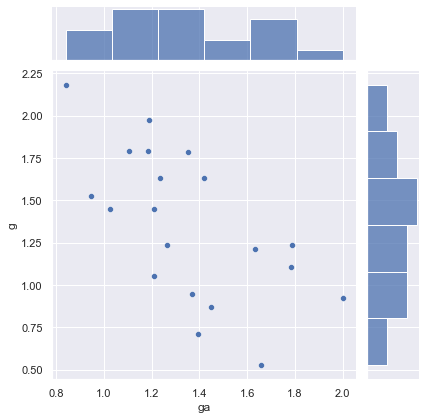

In [35]:
sns.jointplot(data=grouped_teams, x = 'ga', y = 'g')

In [36]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,prev_5_assists,prev_5_bps,fwd_4_pp90,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_pp90_index
66817,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67242,Aaron Connolly,4.0,Brighton,0,2,27,1,11.3,78,16,0,1,6.9,34.8,2020-09-20T13:00:00Z,89,14,2,3.0,0.0,8,55,False,2,2020-21,8.089888,NaN,NaN,NaN,NaN,NaN,NaN,10.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67781,Aaron Connolly,4.0,Brighton,0,0,2,0,12.1,78,19,2,0,1.9,0.0,2020-09-26T11:30:00Z,73,13,3,3.0,2.0,2,55,True,3,2020-21,2.465753,NaN,NaN,NaN,NaN,NaN,NaN,14.433746,4.185214,3.389556,8.089888,4.066667,0.000000,8.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68335,Aaron Connolly,4.0,Brighton,0,0,7,0,0.3,78,32,3,0,0.7,3.0,2020-10-03T14:00:00Z,65,7,4,2.0,4.0,2,55,False,4,2020-21,2.769231,NaN,NaN,NaN,NaN,NaN,NaN,14.543114,4.441624,3.163131,8.089888,3.166667,0.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71872,Aaron Connolly,4.0,Brighton,0,0,0,0,12.0,78,90,1,0,4.0,0.0,2020-11-28T12:30:00Z,62,11,10,1.0,1.0,2,53,True,10,2020-21,2.903226,12.127642,13.16272,30.0,1.92,0.2,5.0,2.743664,18.467742,13.991180,30.000000,2.333333,0.333333,5.333333,10.104014,11.42538,30.0,2.842857,0.142857,7.0,14.892966


In [37]:
team_ids = pd.read_csv('/Users/andrew.peters/Documents/GitHub/Fantasy-Premier-League/data/2020-21/teams.csv')

In [38]:
team_ids = team_ids.rename(columns={x: 'opp_' + x for x in team_ids.columns}) #renaming the columns because i'll merge this with the df for opponent data

In [39]:
list(team_ids)

['opp_code',
 'opp_draw',
 'opp_form',
 'opp_id',
 'opp_loss',
 'opp_name',
 'opp_played',
 'opp_points',
 'opp_position',
 'opp_short_name',
 'opp_strength',
 'opp_team_division',
 'opp_unavailable',
 'opp_win',
 'opp_strength_overall_home',
 'opp_strength_overall_away',
 'opp_strength_attack_home',
 'opp_strength_attack_away',
 'opp_strength_defence_home',
 'opp_strength_defence_away',
 'opp_pulse_id']

In [40]:
df = df.merge(team_ids[['opp_id', 
        'opp_name',
        'opp_strength',
        'opp_strength_overall_home',
        'opp_strength_overall_away',
        'opp_strength_attack_home',
        'opp_strength_attack_away',
        'opp_strength_defence_home',
        'opp_strength_defence_away']], 
        left_on='opponent_team', right_on='opp_id')

In [41]:
df.head()

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,prev_5_assists,prev_5_bps,fwd_4_pp90,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_pp90_index,opp_id,opp_name,opp_strength,opp_strength_overall_home,opp_strength_overall_away,opp_strength_attack_home,opp_strength_attack_away,opp_strength_defence_home,opp_strength_defence_away
0,Aaron Connolly,4.0,Brighton,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,1,3.0,1.0,1,55,True,1,2020-21,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.831218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Chelsea,4,1250,1280,1260,1300,1250,1310
1,Aaron Cresswell,2.0,West Ham,0,0,14,0,20.6,435,131,3,0,3.9,10.0,2020-12-21T20:00:00Z,90,5,14,0.0,3.0,1,52,False,14,2020-21,1.0,2.2,1.643168,5.0,3.68,0.2,13.0,5.500000,2.666667,2.081666,5.0,3.766667,0.333333,14.000000,3.428571,2.507133,7.0,4.600000,0.142857,17.428571,2.679048,5,Chelsea,4,1250,1280,1260,1300,1250,1310
2,Aaron Ramsdale,1.0,Sheffield Utd,0,0,17,0,0.0,483,71,4,0,3.1,30.8,2020-11-07T17:30:00Z,90,5,8,1.0,4.0,2,49,False,8,2020-21,2.0,2.6,0.894427,4.0,2.92,0.0,17.2,2.000000,2.666667,1.154701,4.0,3.233333,0.000000,18.333333,2.714286,0.951190,4.0,2.985714,0.000000,17.428571,2.656190,5,Chelsea,4,1250,1280,1260,1300,1250,1310
3,Aaron Ramsdale,1.0,Sheffield Utd,0,0,4,0,0.0,483,226,2,0,0.0,0.0,2021-02-07T19:15:00Z,90,5,23,2.0,1.0,1,46,True,23,2020-21,1.0,2.2,1.095445,3.0,1.72,0.0,12.4,2.500000,2.333333,1.154701,3.0,1.866667,0.000000,11.666667,3.000000,2.828427,9.0,1.728571,0.000000,14.714286,2.426667,5,Chelsea,4,1250,1280,1260,1300,1250,1310
4,Aaron Wan-Bissaka,2.0,Man Utd,0,0,28,1,4.2,313,55,0,0,2.1,17.0,2020-10-24T16:30:00Z,90,5,6,0.0,0.0,6,54,True,6,2020-21,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4.500000,4.333333,4.725816,8.0,5.700000,0.000000,22.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Chelsea,4,1250,1280,1260,1300,1250,1310


In [42]:
df = df.merge(grouped_teams, left_on='opp_name', right_on='team', suffixes=['', '_opp'])

In [43]:
df = df.drop(columns='team_opp') #redundant column from last merge
df = df.rename(columns={'g': 'opp_avg_g', 'ga': 'opp_avg_ga'})

In [44]:
player_pp90 = df.groupby('name')['pp90'].mean().reset_index()

In [45]:
player_pp90 = player_pp90.rename(columns={'pp90': 'avg_pp90'})

In [46]:
df = df.merge(player_pp90)

In [47]:
df['pct_variance'] = (df['pp90'] - df['avg_pp90']) / df['avg_pp90']

In [48]:
df.corr()['pct_variance'].sort_values()

goals_conceded              -3.172751e-01
opp_avg_g                   -1.367422e-01
opp_strength_overall_home   -1.295987e-01
opp_strength_overall_away   -1.291323e-01
opp_strength_defence_away   -1.263487e-01
opp_strength                -1.237957e-01
opp_strength_defence_home   -1.232962e-01
opp_strength_attack_away    -1.050676e-01
opp_strength_attack_home    -1.038619e-01
team_a_score                -6.159839e-02
team_h_score                -5.862386e-02
value                       -8.102721e-03
fixture                     -5.565677e-03
gw                          -5.162380e-03
round                       -5.162380e-03
avg_pp90                    -1.077886e-17
position                    -5.887005e-18
element                     -7.641553e-19
was_home                     2.833884e-03
opponent_team                1.943313e-02
opp_id                       1.943313e-02
prev_7_std                   2.814277e-02
prev_7_max                   3.298699e-02
prev_5_std                   5.098

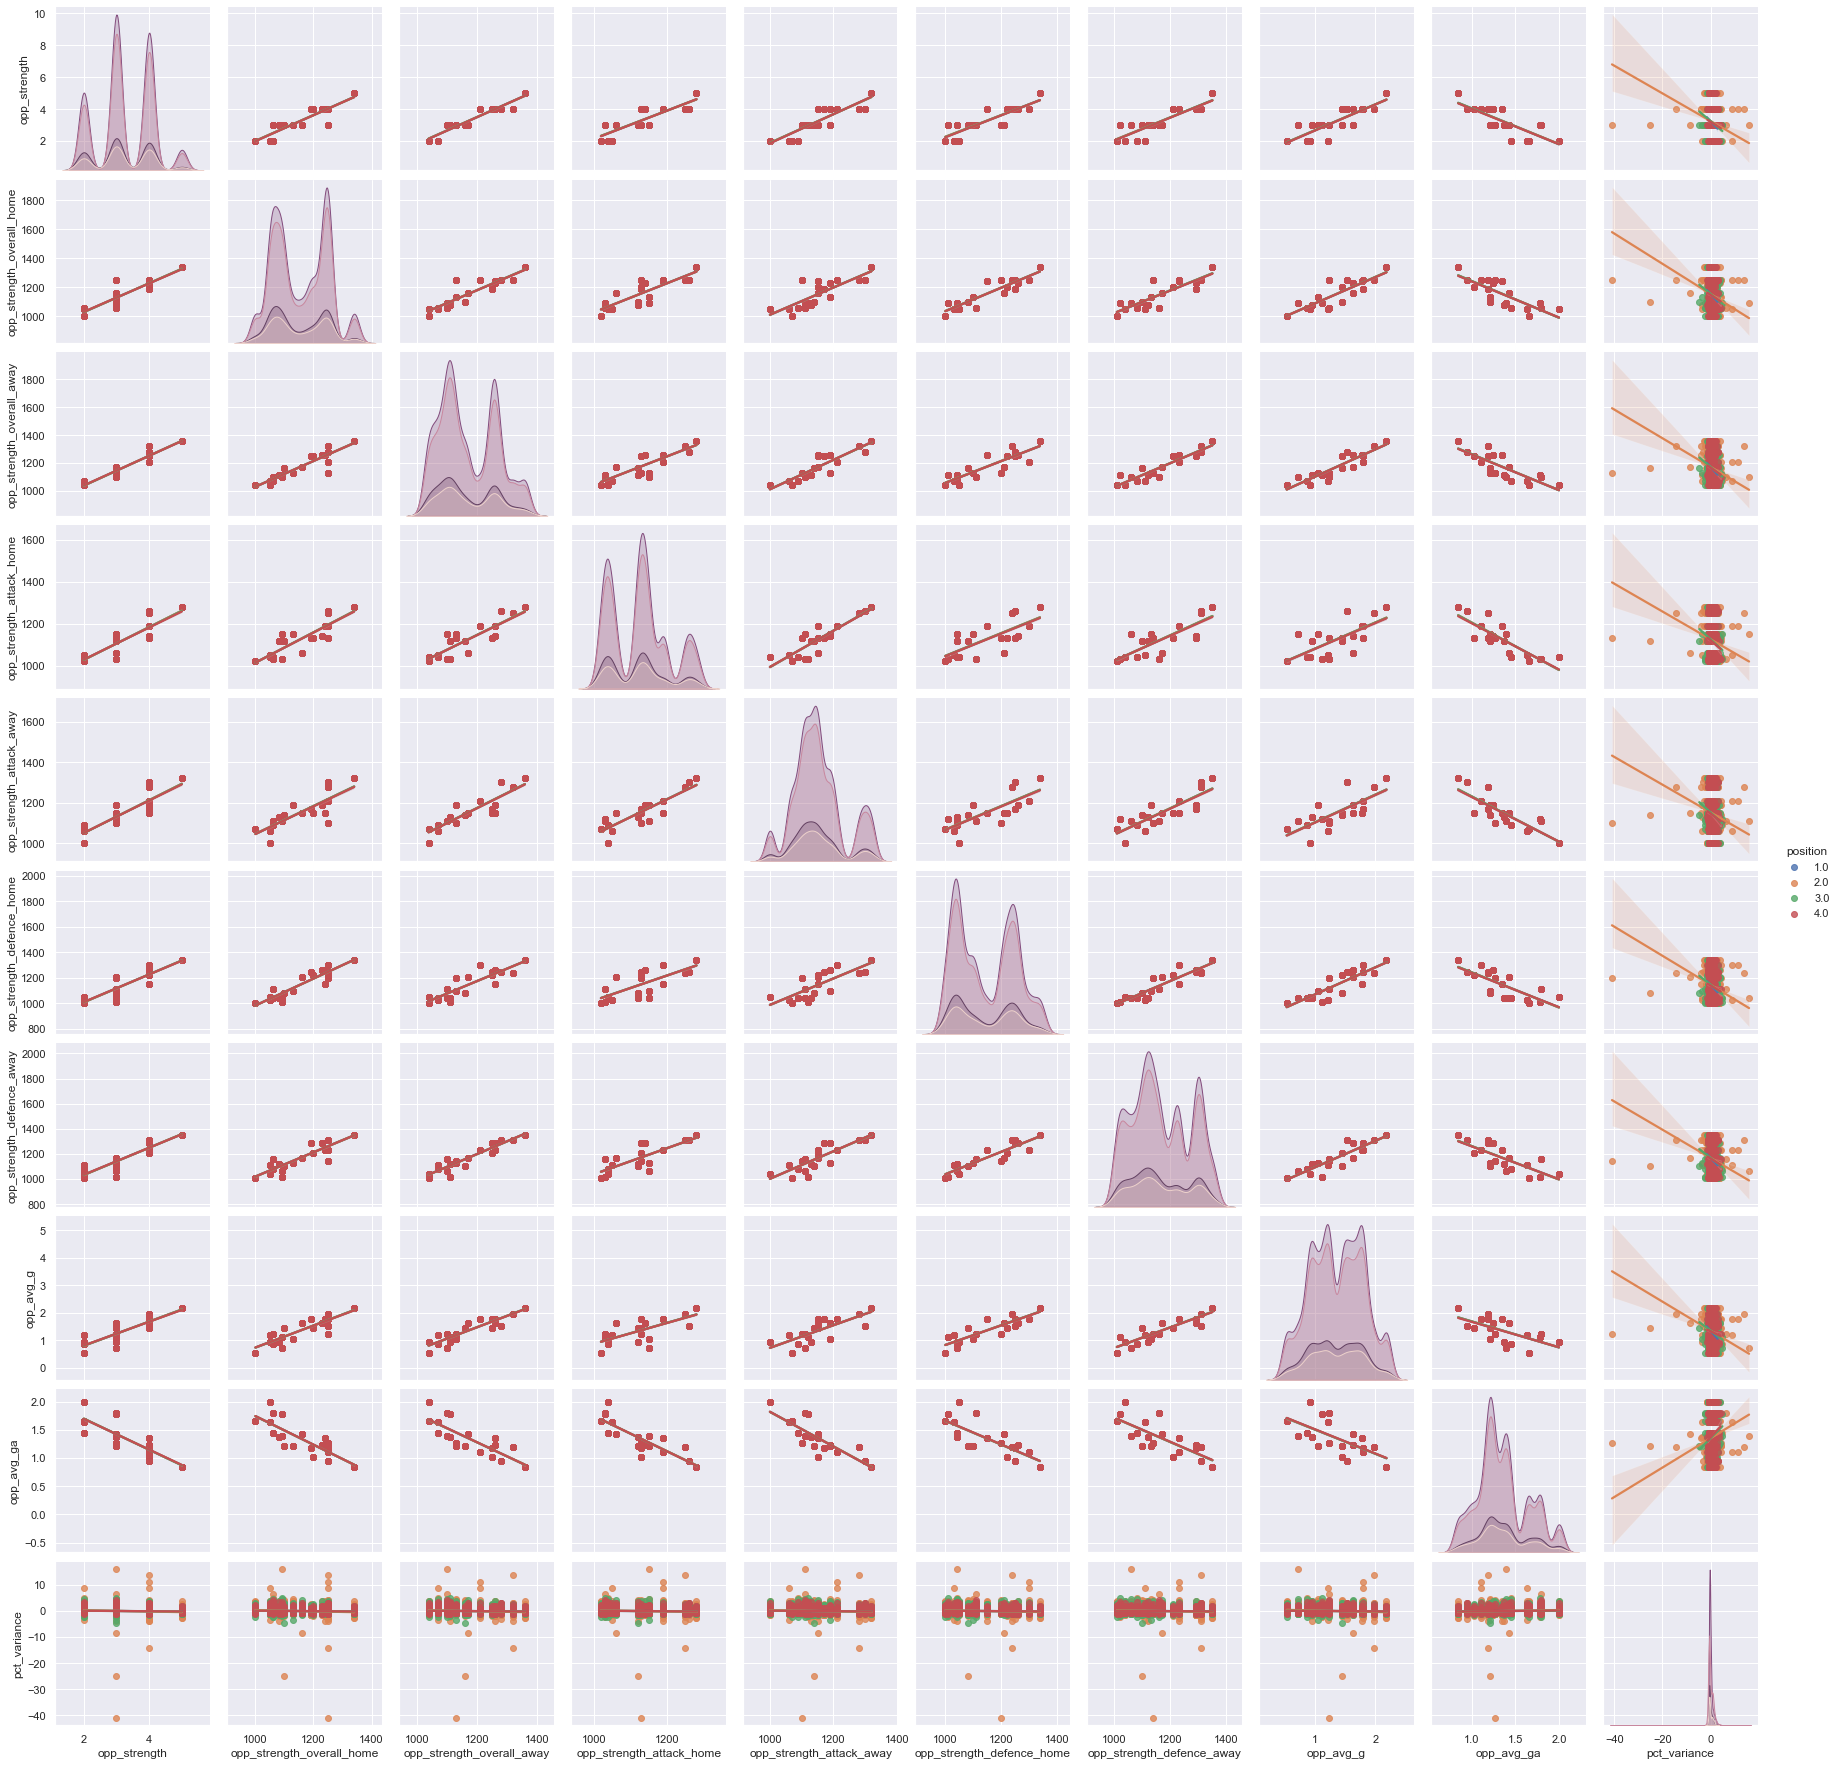

In [49]:
sns.pairplot(df.loc[:, ['position',
        'opp_strength',
        'opp_strength_overall_home',
        'opp_strength_overall_away',
        'opp_strength_attack_home',
        'opp_strength_attack_away',
        'opp_strength_defence_home',
        'opp_strength_defence_away',
        'opp_avg_g',
        'opp_avg_ga',
        'pct_variance']], kind='reg', hue='position')

In [50]:
X = df.opp_avg_ga
Y = df.pct_variance

X_mean = np.mean(X)
Y_mean = np.mean(Y)

num = 0
den = 0
for i in range(len(X)):
    num += (X[i] - X_mean)*(Y[i] - Y_mean)
    den += (X[i] - X_mean)**2
m = num / den
c = Y_mean - m*X_mean

print (m, c)

nan nan


In [51]:
opponent_strenth_data = df.loc[:, ['opp_strength',
                                'opp_strength_overall_home',
                                'opp_strength_overall_away',
                                'opp_strength_attack_home',
                                'opp_strength_attack_away',
                                'opp_strength_defence_home',
                                'opp_strength_defence_away',
                                'opp_avg_g',
                                'opp_avg_ga',
                                'pct_variance']]

In [52]:
opponent_strenth_data.dropna(inplace=True)

In [53]:
opp_ga_fit = np.polynomial.Polynomial.fit(opponent_strenth_data.opp_avg_ga, opponent_strenth_data.pct_variance, 1)
opp_g_fit = np.polynomial.Polynomial.fit(opponent_strenth_data.opp_avg_g, opponent_strenth_data.pct_variance, 1)

In [54]:
print(opp_ga_fit)
print(opp_g_fit)

0.027138606869939283 + 0.23178736387564453·x¹
-0.0012633397274773497 - 0.27286481310029215·x¹


In [55]:
opp_g_fit

Polynomial([-0.00126334, -0.27286481], domain=[0.52631579, 2.18421053], window=[-1.,  1.])

In [56]:
#I can use the above to make a calculation for how a player's pp90 changes based on the mean goals for or mean goals against of the opponent

In [57]:
df.loc[:, ['avg_pp90', 'pp90', 'opp_avg_g']]

,avg_pp90,pp90,opp_avg_g
0,3.730551,2.000000,1.526316
1,3.730551,8.089888,1.210526
2,3.730551,2.465753,1.972973
3,3.730551,2.769231,1.236842
4,3.730551,2.903226,1.789474
...,...,...,...
8648,2.000000,2.000000,1.631579
8649,0.000000,0.000000,1.108108
8650,2.535211,2.535211,1.052632
8651,6.750000,6.750000,1.631579


In [58]:
starter_predictions = df.groupby(['name', 'element']).agg({'total_points': 'sum', 'pp90': 'mean'}).reset_index().sort_values('total_points', ascending=False)

In [59]:
starter_predictions.to_csv('starter_predictions.csv')

In [60]:
df[df.name == 'Bruno Miguel Borges Fernandes']

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,prev_5_assists,prev_5_bps,fwd_4_pp90,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_pp90_index,opp_id,opp_name,opp_strength,opp_strength_overall_home,opp_strength_overall_away,opp_strength_attack_home,opp_strength_attack_away,opp_strength_defence_home,opp_strength_defence_away,opp_avg_g,opp_avg_ga,avg_pp90,pct_variance
981,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,14,1,60.9,302,55,0,0,9.6,18.6,2020-10-24T16:30:00Z,90,5,6,0.0,0.0,3,105,True,6,2020-21,3.000000,8.000000,5.049752,12.000000,12.80,0.4,27.4,8.358108,8.666667,4.932883,12.000000,13.033333,0.333333,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Chelsea,4,1250,1280,1260,1300,1250,1310,1.526316,0.947368,7.271042,-0.587404
982,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,7,1,16.8,302,249,0,0,4.6,11.0,2021-02-28T16:30:00Z,90,5,26,0.0,0.0,3,116,False,26,2020-21,3.000000,9.600000,5.272571,17.000000,12.08,0.6,30.8,4.750000,8.000000,4.582576,12.000000,9.066667,0.333333,23.666667,7.571429,5.533448,17.000000,10.557143,0.428571,25.285714,8.394286,5,Chelsea,4,1250,1280,1260,1300,1250,1310,1.526316,0.947368,7.271042,-0.587404
983,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,3,49,0,78.7,302,45,1,1,22.0,85.4,2020-10-17T19:00:00Z,90,14,5,4.0,1.0,11,105,False,5,2020-21,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.358108,11.666667,0.577350,12.000000,13.833333,0.666667,36.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,Newcastle,2,1050,1070,1050,1060,1030,1110,1.210526,1.631579,7.271042,0.512851
984,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,3,41,0,43.6,302,245,1,1,13.3,60.8,2021-02-21T19:00:00Z,90,14,25,1.0,3.0,12,116,True,25,2020-21,12.000000,9.600000,5.272571,17.000000,11.98,0.6,31.0,7.000000,9.333333,2.516611,12.000000,11.133333,0.333333,31.000000,7.857143,5.304984,17.000000,10.957143,0.571429,27.142857,9.118095,14,Newcastle,2,1050,1070,1050,1060,1030,1110,1.210526,1.631579,7.271042,0.650382
985,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,3,51,0,21.2,302,73,1,2,17.3,93.6,2020-11-07T12:30:00Z,90,7,8,3.0,1.0,17,105,False,8,2020-21,17.000000,9.086486,6.246910,17.000000,11.98,0.4,28.4,12.500000,7.477477,8.251628,17.000000,10.133333,0.333333,24.000000,8.490347,5.948595,17.000000,12.114286,0.428571,27.857143,8.162754,7,Everton,3,1250,1130,1130,1100,1200,1140,1.236842,1.263158,7.271042,1.338042
986,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,29,0,53.3,302,224,3,1,10.8,35.0,2021-02-06T20:00:00Z,90,7,23,3.0,3.0,7,115,True,23,2020-21,7.000000,6.800000,6.016644,17.000000,10.82,0.6,25.2,7.750000,9.000000,7.211103,17.000000,12.433333,0.666667,30.333333,5.587662,5.339223,17.000000,10.171429,0.428571,20.285714,7.657532,7,Everton,3,1250,1130,1130,1100,1200,1140,1.236842,1.263158,7.271042,-0.037277
987,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,0,3,1,24.5,302,184,0,0,7.9,7.4,2021-01-17T16:30:00Z,88,11,19,0.0,0.0,3,113,False,19,2020-21,3.068182,6.715751,4.404820,12.000000,12.16,0.4,21.0,3.267045,5.192918,4.594404,10.465116,10.866667,0.000000,16.666667,8.244911,7.190185,21.857143,11.671429,0.428571,25.142857,6.260166,11,Liverpool,4,1250,1210,1190,1210,1300,1230,1.789474,1.105263,7.271042,-0.578027
988,Bruno Miguel Borges Fernandes,3.0,Man Utd,0,1,34,0,29.3,302,334,4,1,12.2,41.4,2021-05-13T19:15:00Z,90,11,35,4.0,2.0,8,115,True,35,2020-21,8.000000,6.217647,3.607806,10.588235,8.58,0.0,16.6,NaN,8.696078,1.657617,10.588235,9.000000,0.000000,21.000000,5.444387,3.340701,10.588235,8.614286,0.142857,17.000000,7.302211,11,Liverpool,4,1250,1210,1190,1210,1300,1230,1.789474,1.105263,7.271042,0.100255
989,Bruno Miguel Borges Fernandes,3.0,Man Utd,1,0,26,0,20.1,302,96,2,1,11.0,35.6,2020-11-29T14:00:00Z,90,16,10,3.0,2.0,10,108,False,10,2020-21,10.000000,8.686486

In [63]:
df.groupby('opp_strength')['pp90'].mean()

opp_strength
2    4.385098
3    3.820130
4    3.149814
5    2.510493
Name: pp90, dtype: float64

In [64]:
#dataframe that select the top 30 performers for each gameweek, by total points
top_30_gw = df.sort_values('total_points', ascending=False).groupby('gw').head(30).sort_values('gw')

In [69]:
top_30_gw.groupby('opp_strength')['total_points'].agg(['sum', 'count', 'mean'])

,sum,count,mean
opp_strength,,,
2,2995,310,9.661290
3,4871,499,9.761523
4,2928,312,9.384615
5,182,19,9.578947


<AxesSubplot:xlabel='opp_avg_ga', ylabel='pct_variance'>

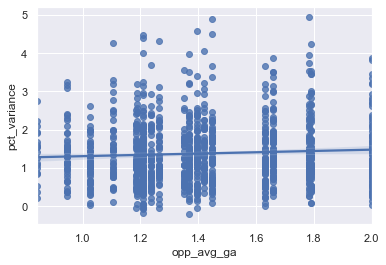

In [77]:
sns.regplot(data=top_30_gw, x='opp_avg_ga', y='pct_variance')

In [84]:
top_earners = df.groupby('name')['total_points'].sum().reset_index().sort_values('total_points', ascending=False).head(100)

In [90]:
list(df)

['name',
 'position',
 'team',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'element',
 'fixture',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'kickoff_time',
 'minutes',
 'opponent_team',
 'round',
 'team_a_score',
 'team_h_score',
 'total_points',
 'value',
 'was_home',
 'gw',
 'season',
 'pp90',
 'prev_5_pp90',
 'prev_5_std',
 'prev_5_max',
 'prev_5_ict',
 'prev_5_assists',
 'prev_5_bps',
 'fwd_4_pp90',
 'prev_3_pp90',
 'prev_3_std',
 'prev_3_max',
 'prev_3_ict',
 'prev_3_assists',
 'prev_3_bps',
 'prev_7_pp90',
 'prev_7_std',
 'prev_7_max',
 'prev_7_ict',
 'prev_7_assists',
 'prev_7_bps',
 'prev_pp90_index',
 'opp_id',
 'opp_name',
 'opp_strength',
 'opp_strength_overall_home',
 'opp_strength_overall_away',
 'opp_strength_attack_home',
 'opp_strength_attack_away',
 'opp_strength_defence_home',
 'opp_strength_defence_away',
 'opp_avg_g',
 'opp_avg_ga',
 'avg_pp90',
 'pct_variance']

<AxesSubplot:xlabel='opp_strength', ylabel='pct_variance'>

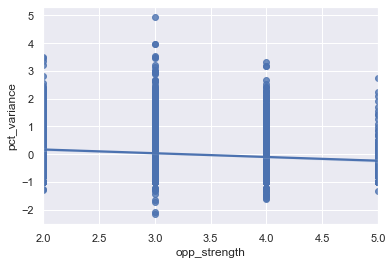

In [93]:
sns.regplot(data=df[df.name.isin(top_earners.name)], x='opp_strength', y='pct_variance')

In [104]:
def q75(x):
    return x.quantile(0.75)
    
def q90(x):
    return x.quantile(0.9)

In [106]:
df[df.name.isin(top_earners.name)].groupby('opp_strength')[['total_points', 'pct_variance']].agg(['sum', 'mean', 'count', q75, q90])

total_points                         pct_variance                                    
                      sum      mean count q75 q90          sum      mean count       q75       q90
opp_strength                                                                                      
2                    3105  4.874411   637   7  10    84.043489  0.131936   637  0.642924  1.299589
3                    5740  4.551943  1261   6  10    87.363195  0.069281  1261  0.606335  1.241993
4                    4202  3.785586  1110   6   8  -135.707287 -0.122259  1110  0.323012  0.983297
5                     468  3.120000   150   4   7   -35.699397 -0.237996   150  0.043977  0.693114

On average, players
- underperform their average by ~24% when playing against a team with an FDR of 5
- underperform by 12% against a 4, 
- essentially average against a team with a rating of 3
- overperform by about 13% by a team with a rating of 2

In [99]:
for x in [4.87, 4.55, 3.78, 3.12]:
    print(x/4.55)

1.0703296703296703
1.0
0.8307692307692307
0.6857142857142857


But it's also clear that players rarely earn their big points in games against opponents of strength 4 or 5 -- especially not 5

The top 100 points earners in 2020/21 averaged 3.12 in FDR 5 games, and almost 1.5x that -- 4.55 -- in FDR3 games

When we look at when players outperform a 75th percentile overperformance again a FDR 2 or 3 team is 60-64% of average, and 90th percentile overperformace -- the big points hauls is 125-130%. On the flip side, those numbers are 5-30%, and 70-99% for FDR 4 & 5 opponents

Takeaways:

- A FDR 2 game isn't much better than an FDR 3 game
- But an FDR 3 game is much better than a FDR 4 game
- And an FDR 4 game is much better again than FDR 5

<AxesSubplot:>

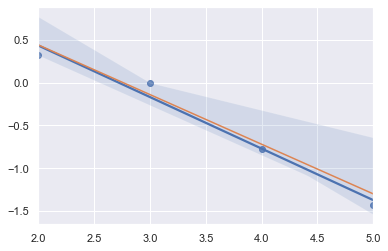

In [185]:
sns.regplot(x = [2, 3, 4, 5], y = [x - 4.55 for x in [4.87, 4.55, 3.78, 3.12]])
sns.lineplot(x=[2,3,4,5], y=[-.58*x + 1.6 for x in [2, 3, 4, 5]])

In [ ]:
#and here we have our FDR predicted points coversion: -.58 * (FDR) + 6.1

In [117]:
def get_latest_data():
    #first, pull the ids for all players
    url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
    r = requests.get(url)
    json = r.json()
    elements_df = pd.DataFrame(json['elements']) #probably a more efficient way to this than a df
    
    #using the player ids from elements_df, pull in detailed player info
    # I'm going compile two dataframes -- one that shows gw by gw history for each player (this season), and 
    # another that shows games to be played
    history_df = pd.DataFrame()
    fixtures_df = pd.DataFrame()

    for player in tqdm(elements_df.id):
        url = f'https://fantasy.premierleague.com/api/element-summary/{player}/'
        r = requests.get(url)
        json = r.json()
        player_history_df = pd.DataFrame(json['history'])
        player_fixtures_df = pd.DataFrame(json['fixtures'])
        player_fixtures_df.loc[:, 'element'] = player
        history_df = history_df.append(player_history_df)
        fixtures_df = fixtures_df.append(player_fixtures_df)
    
    return history_df, fixtures_df

In [176]:
def get_player_info():
    url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
    r = requests.get(url)
    json = r.json()

    #pull player info
    elements_df = pd.DataFrame(json['elements'])
    elements_df['player'] = elements_df['first_name'] + '_' + elements_df['second_name']
    elements_df = elements_df.loc[:, ['id', 'element_type', 'team_code', 'player',  'total_points', 'points_per_game', 'chance_of_playing_this_round', 'now_cost', 'penalties_order']]
    
    #merge in team names
    teams_df = pd.DataFrame(json['teams'])
    elements_df = elements_df.merge(teams_df[['code', 'name']], left_on = 'team_code', right_on='code')
    
    return elements_df, teams_df

In [122]:
def prep_unplayed_fixtures():
    #only need to keep some columns
    fixtures = unplayed_fixtures_df[['element', 'team_h', 'team_a', 'event_name', 'kickoff_time', 'finished', 'is_home']]
    
    #games far enough in the future don't have a date assigned, not useful
    fixtures = fixtures.dropna()
    
    #helper function for stripping letters from gameweek column
    def strip_letters(string):
        return re.sub('\D', '', string)
    
    # convert 'Gameweek 25' to just '25' (as an int)
    fixtures.loc[:, 'gw'] = fixtures.apply(lambda x: strip_letters(x['event_name']), axis=1)
    
    #bring in player-level info to each unplayed fixture row
    fixtures = fixtures.merge(df[['element', 'player', 'position', 'team']], how='left', on='element')
    
    #the merge causes many duplicates, because each player has many rows in df
    fixtures = fixtures.drop_duplicates(subset=['element', 'kickoff_time'], keep = 'last')
    
    #make a dictionary using the team ids and team names, and then use that dictionary to fill in the 'team_opponent' col
    # with an intelligible name

    team_dict = dict(zip(teams_df.id,teams_df.name))
    fixtures.loc[fixtures.is_home == True, 'opponent_team'] = fixtures.loc[fixtures.is_home == True, 'team_a'].replace(team_dict)
    fixtures.loc[fixtures.is_home == False, 'opponent_team'] = fixtures.loc[fixtures.is_home == False, 'team_h'].replace(team_dict)
    
    #drop columns we no longer need
    fixtures = fixtures.drop(columns=['team_h', 'team_a', 'event_name'])
    
    return fixtures

In [135]:
def append_historical_current_df():

    # merge in some of the basic player info from the elements df
    merged_current_season_df = current_season_df.merge(elements_df, left_on = 'element', right_on = 'id')
    merged_current_season_df = merged_current_season_df.rename(columns={'element_type': 'position',
                                     'round': 'gw',
                                      'name': 'team',
                                      'chance_of_playing_this_round': 'play_proba'
                                     })
    merged_current_season_df['season'] = 2022
    
    #add in opp team names
    merged_current_season_df = merged_current_season_df.merge(teams_df[['id', 'name']], left_on = 'opponent_team', right_on = 'id')
    merged_current_season_df['opponent_team'] = merged_current_season_df['name']

    #append the newly merged current season df with the previous season
    #df = merged_current_season_df.append(previous_season_df)
    
    #drop columns that only were in one df or the other prior to appending, and that we're not going to use
    df = df.drop(columns=['fixture', 'value', 'team_code', 'code', 'relative_market_value_team',
            'relative_market_value_opponent_team', 'relative_market_value_team_season',
            'relative_market_value_opponent_team_season', 'name'])

    return df

In [118]:
current_season_df, unplayed_fixtures_df = get_latest_data()

100%|██████████| 525/525 [00:58<00:00,  8.96it/s]


In [139]:
#since there have been no games yet:
current_season_df = unplayed_fixtures_df

In [177]:
elements_df, teams_df = get_player_info()

In [158]:
elements_df.player = elements_df.player.str.replace('_', ' ')

In [192]:
df_2122 = unplayed_fixtures_df.merge(elements_df[['id', 'element_type', 'player', 'name', 'now_cost', 'total_points', 'points_per_game']], left_on='element', right_on='id')

In [193]:
df_2122.event_name = df_2122.event_name.str.replace('Gameweek ', '').astype('int')

In [194]:
df_2122.head()

,id_x,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,id_y,element_type,player,name,now_cost,total_points,points_per_game
0,1,2210271,3,None,1,None,1,False,0,False,2021-08-13T19:00:00Z,1,False,2,1,1,1,Bernd_Leno,Arsenal,50,131,3.7
1,18,2210281,1,None,6,None,2,False,0,False,2021-08-22T15:30:00Z,2,True,4,1,1,1,Bernd_Leno,Arsenal,50,131,3.7
2,24,2210295,12,None,1,None,3,False,0,False,2021-08-28T11:30:00Z,3,False,5,1,1,1,Bernd_Leno,Arsenal,50,131,3.7
3,31,2210301,1,None,15,None,4,False,0,False,2021-09-11T14:00:00Z,4,True,2,1,1,1,Bernd_Leno,Arsenal,50,131,3.7
4,43,2210313,5,None,1,None,5,False,0,False,2021-09-18T14:00:00Z,5,False,2,1,1,1,Bernd_Leno,Arsenal,50,131,3.7


In [199]:
#very basic formula to adjust for fixture difficulty -- probably should proportionally adjust from player's average, but good enough for now
def fdr_adjust(fdr, avg_points):
    return((-.58*fdr + 1.6) + avg_points)

In [220]:
df_2122['points_per_game_played'] = df_2122.points_per_game.astype('float')
df_2122.difficulty = df_2122.difficulty.astype('float')

In [221]:
df_2122['avg_points'] = df_2122.total_points/38

In [222]:
df_2122['adj_avg_points'] = df_2122.apply(lambda x: fdr_adjust(x.difficulty, x.avg_points), axis=1)
df_2122['adj_points_per_game_played'] = df_2122.apply(lambda x: fdr_adjust(x.difficulty, x.points_per_game_played), axis=1)

In [224]:
df_2122 = df_2122.drop(columns='points_per_game')

In [232]:
df_2122.head()

,id_x,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,id_y,element_type,player,name,now_cost,total_points,adj_points,points_per_game_played,avg_points,adj_avg_points,adj_points_per_game_played
0,1,2210271,3,None,1,None,1,False,0,False,2021-08-13T19:00:00Z,1,False,2.0,1,1,1,Bernd_Leno,Arsenal,50,131,4.14,3.7,3.447368,3.887368,4.14
1,18,2210281,1,None,6,None,2,False,0,False,2021-08-22T15:30:00Z,2,True,4.0,1,1,1,Bernd_Leno,Arsenal,50,131,2.98,3.7,3.447368,2.727368,2.98
2,24,2210295,12,None,1,None,3,False,0,False,2021-08-28T11:30:00Z,3,False,5.0,1,1,1,Bernd_Leno,Arsenal,50,131,2.40,3.7,3.447368,2.147368,2.40
3,31,2210301,1,None,15,None,4,False,0,False,2021-09-11T14:00:00Z,4,True,2.0,1,1,1,Bernd_Leno,Arsenal,50,131,4.14,3.7,3.447368,3.887368,4.14
4,43,2210313,5,None,1,None,5,False,0,False,2021-09-18T14:00:00Z,5,False,2.0,1,1,1,Bernd_Leno,Arsenal,50,131,4.14,3.7,3.447368,3.887368,4.14


In [236]:
initial_predictions = df_2122[df_2122['event_name'] <=5]

In [239]:
initial_predictions = initial_predictions.groupby(['player', 'name', 
        'element_type', 'now_cost'])[['adj_avg_points', 'adj_points_per_game_played']].sum().reset_index()

In [240]:
initial_predictions.to_csv('initial_predictions.csv')

In [218]:
df[df.name == 'Caoimhin_Kelleher']

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,round,team_a_score,team_h_score,total_points,value,was_home,gw,season,pp90,prev_5_pp90,prev_5_std,prev_5_max,prev_5_ict,prev_5_assists,prev_5_bps,fwd_4_pp90,prev_3_pp90,prev_3_std,prev_3_max,prev_3_ict,prev_3_assists,prev_3_bps,prev_7_pp90,prev_7_std,prev_7_max,prev_7_ict,prev_7_assists,prev_7_bps,prev_pp90_index,opp_id,opp_name,opp_strength,opp_strength_overall_home,opp_strength_overall_away,opp_strength_attack_home,opp_strength_attack_away,opp_strength_defence_home,opp_strength_defence_away,opp_avg_g,opp_avg_ga,avg_pp90,pct_variance


In [217]:
df_2122[df_2122.player == 'Caoimhin_Kelleher']

,id_x,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,id_y,element_type,player,name,now_cost,total_points,points_per_game,adj_points
10488,7,2210278,15,None,11,None,1,False,0,False,2021-08-14T16:30:00Z,1,False,2.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,5.44
10489,15,2210286,11,None,5,None,2,False,0,False,2021-08-21T11:30:00Z,2,True,2.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,5.44
10490,23,2210294,11,None,6,None,3,False,0,False,2021-08-28T16:30:00Z,3,True,4.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,4.28
10491,36,2210306,10,None,11,None,4,False,0,False,2021-09-12T15:30:00Z,4,False,3.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,4.86
10492,44,2210314,11,None,7,None,5,False,0,False,2021-09-18T14:00:00Z,5,True,2.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,5.44
10493,52,2210322,3,None,11,None,6,False,0,False,2021-09-25T16:30:00Z,6,False,2.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,5.44
10494,66,2210336,11,None,12,None,7,False,0,False,2021-10-03T15:30:00Z,7,True,4.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,4.28
10495,80,2210350,18,None,11,None,8,False,0,False,2021-10-16T11:30:00Z,8,False,2.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,5.44
10496,88,2210358,13,None,11,None,9,False,0,False,2021-10-24T15:30:00Z,9,False,4.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,4.28
10497,94,2210364,11,None,4,None,10,False,0,False,2021-10-30T14:00:00Z,10,True,2.0,242,242,1,Caoimhin_Kelleher,Liverpool,45,10,5.0,5.44
